## Exploring the Double Descent phenomenon in Deep Learning Methods using variable architectures, data and model parameters

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds

import re
from nltk.tokenize.treebank import TreebankWordDetokenizer
from gensim.utils import simple_preprocess

import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from glob import glob
from tqdm import tqdm

###Enabling GPU
Because we might be working with huge amounts of data, GPU is used with tensorflow to accelrate the processing. The only drawback with using the GPU on colab is that we can only use it 12 hours at time. We will only be able to use it after another 12 hours after last use.

In [ ]:
# check if GPU is accessible with tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# command to check GPU status
!nvidia-smi

Sat May  7 23:27:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###Dataset Loading and Preparation

The dataset we are about to use is the 'Sentiment140' dataset which has information regarding a tweet. And we are going to find the polarity of that tweet using sentiment analysis through neural networks!

In [ ]:
# Seperation of data into train and test sets
ds_train, ds_train_info = tfds.load('sentiment140', split='train[:4%]', shuffle_files=True ,with_info = True) # Loading a built in tensorflow dataset
#ds_test, ds_test_info = tfds.load('sentiment140', split='test[:5%]', shuffle_files=True , with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/sentiment140/1.0.0.incomplete4NPN7Y/sentiment140-train.tfrecord


  0%|          | 0/1600000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/sentiment140/1.0.0.incomplete4NPN7Y/sentiment140-test.tfrecord


  0%|          | 0/498 [00:00<?, ? examples/s]

Dataset sentiment140 downloaded and prepared to /root/tensorflow_datasets/sentiment140/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Features of the dataset
for i in ds_train.take(1): 
  print(list(i.keys()))

['date', 'polarity', 'query', 'text', 'user']


In [ ]:
# Taking the first four rows of the dataset and seeing as a dataframe
tfds.as_dataframe(ds_train.take(4))

,date,polarity,query,text,user
0,b'Mon Jun 01 18:08:26 PDT 2009',4,b'NO_QUERY',"b""i'm 10x cooler than all of you! """,b'katie4593'
1,b'Mon Jun 01 23:55:43 PDT 2009',0,b'NO_QUERY',b'O.kk? Thats weird I cant stop following people on twitter... I have tons of people to unfollow ',b'migaruler'
2,b'Mon May 04 06:08:51 PDT 2009',4,b'NO_QUERY',b'what a beautiful day not to got to my first class ',b'ocean_waves301'
3,b'Sun May 31 18:42:57 PDT 2009',4,b'NO_QUERY',"b"".@HildyGottlieb & I was just saying to Maha'al yesterday, everything we ever needed to know was in Beatles' lyrics - you prove my point! """,b'TerraScene'


In [ ]:
# More info regarding the dataset
print(ds_train_info.features)

FeaturesDict({
    'date': Text(shape=(), dtype=tf.string),
    'polarity': tf.int32,
    'query': Text(shape=(), dtype=tf.string),
    'text': Text(shape=(), dtype=tf.string),
    'user': Text(shape=(), dtype=tf.string),
})


For data preparation, only the polarity as the label and the tweet text as the feature is taken for training. The tweet text is cleaned by removing unnecessary symbols. The labels are encoded in order to pass it to the convolution neural network model.

In [ ]:
# Using it as a numpy array
train_text, train_polarity = tfds.as_numpy(tfds.load('sentiment140', split='train[:4%]', shuffle_files=True, batch_size=-1,
    as_supervised=True ))

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [ ]:
print(type(train_text), train_text.shape)
print(type(train_polarity), train_polarity.shape)


<class 'numpy.ndarray'> (64000,)
<class 'numpy.ndarray'> (64000,)


In [ ]:
train_text[:10] # First ten tweet records

array([b"i'm 10x cooler than all of you! ",
       b'O.kk? Thats weird I cant stop following people on twitter... I have tons of people to unfollow ',
       b'what a beautiful day not to got to my first class ',
       b".@HildyGottlieb &amp; I was just saying to Maha'al yesterday, everything we ever needed to know was in Beatles' lyrics - you prove my point! ",
       b'kinda sad and confused  why do guys do this?',
       b'@Real_DavidCook YES &amp; YES ',
       b"@GDGOfficial But it's another beautiful day here in europe, you have to make the most of it  Rock the house again tonight!",
       b'Working through hundreds of assignments ',
       b'driving with the moonroof and windows open is THE BEST THING IN THE WORLD. Sitting on the couch with @melissasmirn she hates my hamster ',
       b"@scott_mills Gutted! I worked for the fringe last year, won't be back this year "],
      dtype=object)

###Data Cleaning and Formatting
Pre-Processing the data to remove non-useful information
A) E-mails
B) URLs
C) Special Characters


In [ ]:
def clean_data(data):
    data = str(data)
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Removing the b" " 
    data = re.sub("b\'", "", data)
    data = re.sub("b\"", "", data)

    # Remove distracting single quotes and double quotes
    data = re.sub("\'", "", data)
    data = re.sub("\"", "", data)
      
    return data

In [ ]:
# Applying function to numpy
clean_lamb =  lambda data: clean_data(data)
clean_v_func = np.vectorize(clean_lamb)
train_text = clean_v_func(train_text)

In [ ]:
train_text[:10]

array(['im 10x cooler than all of you! ',
       'O.kk? Thats weird I cant stop following people on twitter... I have tons of people to unfollow ',
       'what a beautiful day not to got to my first class ',
       '&amp; I was just saying to Mahaal yesterday, everything we ever needed to know was in Beatles lyrics - you prove my point! ',
       'kinda sad and confused why do guys do this?', 'YES &amp; YES ',
       'But its another beautiful day here in europe, you have to make the most of it Rock the house again tonight!',
       'Working through hundreds of assignments ',
       'driving with the moonroof and windows open is THE BEST THING IN THE WORLD. Sitting on the couch with she hates my hamster ',
       'Gutted! I worked for the fringe last year, wont be back this year '],
      dtype='<U1653')

Here we are writing a function for converting sentences to words and then back to sentences after removing noise then tokenizing the sentences into words and setting the deacc parameter to True removes punctuations

In [ ]:
def convert_to_words(sentences):
  list_of_words = simple_preprocess(str(sentences), deacc=True)
  return TreebankWordDetokenizer().detokenize(list_of_words) # Makes words go back to sentences

In [ ]:
convert_lamb =  lambda data: convert_to_words(data)
convert_v_func = np.vectorize(convert_lamb)
train_text = convert_v_func(train_text)

In [ ]:
train_text[:10]

array(['im cooler than all of you',
       'kk thats weird cant stop following people on twitter have tons of people to unfollow',
       'what beautiful day not to got to my first class',
       'amp was just saying to mahaal yesterday everything we ever needed to know was in beatles lyrics you prove my point',
       'kinda sad and confused why do guys do this', 'yes amp yes',
       'but its another beautiful day here in europe you have to make the most of it rock the house again tonight',
       'working through hundreds of assignments',
       'driving with the moonroof and windows open is the best thing in the world sitting on the couch with she hates my hamster',
       'gutted worked for the fringe last year wont be back this year'],
      dtype='<U1141')

In [ ]:
print(np.unique(train_polarity)) # 0 - negative , 4 - positive
Y_Tr = train_polarity
print(Y_Tr[0])

[0 4]
4


In [ ]:
# Encoding the labels
train_polarity[train_polarity == 4] = 1 # Replacing the values to 1

In [ ]:
train_polarity[90]

1

Split the same dataset into train and validation datasets.

In [ ]:
# Train - validation spilt
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_text, train_polarity, test_size=0.33, random_state=42)

### Model construction and training

The words are tokenized using a keras preprocessing layer.
For the model 1D convolution model is used. It is extremely fast on small datastets and it converges faster.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import keras
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras import Model, layers
from keras import Input

from keras.callbacks import EarlyStopping

Assign numbers to words to use convolutional network on it.

In [ ]:
max_len=max([len(row.split()) for row in train_text])
print("Maximum length:",max_len)

Maximum length: 375


In [ ]:
tokenizer = Tokenizer() # Defining a tokenizer
tokenizer.fit_on_texts(X_train) # Applying it to the numpy array of texts
sequences = tokenizer.texts_to_sequences(X_train) # Converting words to sequence of numbers
train_text = pad_sequences(sequences, maxlen=max_len , padding="post") # Padding them for convolution

In [ ]:
tokenizer.word_index['hit']

540

In [ ]:
train_text

array([[ 15,  34, 476, ...,   0,   0,   0],
       [  2, 106,  56, ...,   0,   0,   0],
       [ 23, 445,  21, ...,   0,   0,   0],
       ...,
       [441, 573, 188, ...,   0,   0,   0],
       [344, 123,  20, ...,   0,   0,   0],
       [460,  30, 356, ...,   0,   0,   0]], dtype=int32)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(X_test) # Converting words to sequence of numbers
test_text = pad_sequences(test_sequences, maxlen=max_len, padding="post") # Padding them for convolution

In [ ]:
test_text.shape

(21120, 375)

In [ ]:
vocab_size=len(tokenizer.word_index) + 1
print(vocab_size)

31617


In [ ]:
model= Sequential()
model.add(layers.Embedding(vocab_size, 100, input_length=max_len))
model.add(layers.Conv1D(32, 8, activation="relu"))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1,  activation="sigmoid"))   

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 375, 100)          3161700   
                                                                 
 conv1d (Conv1D)             (None, 368, 32)           25632     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 184, 32)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5888)              0         
                                                                 
 dense (Dense)               (None, 10)                58890     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                        

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_text,y_train, validation_data= ( test_text , y_test),epochs=20)

Epoch 1/20
1340/1340 [==============================] - 19s 6ms/step - loss: 0.5371 - accuracy: 0.7204 - val_loss: 0.4782 - val_accuracy: 0.7754
Epoch 2/20
1340/1340 [==============================] - 7s 5ms/step - loss: 0.3614 - accuracy: 0.8454 - val_loss: 0.5121 - val_accuracy: 0.7620
Epoch 3/20
1340/1340 [==============================] - 8s 6ms/step - loss: 0.1962 - accuracy: 0.9246 - val_loss: 0.6210 - val_accuracy: 0.7500
Epoch 4/20
1340/1340 [==============================] - 7s 5ms/step - loss: 0.0944 - accuracy: 0.9655 - val_loss: 0.8392 - val_accuracy: 0.7437
Epoch 5/20
1340/1340 [==============================] - 7s 6ms/step - loss: 0.0545 - accuracy: 0.9803 - val_loss: 1.0828 - val_accuracy: 0.7418
Epoch 6/20
1340/1340 [==============================] - 7s 5ms/step - loss: 0.0357 - accuracy: 0.9873 - val_loss: 1.2321 - val_accuracy: 0.7399
Epoch 7/20
1340/1340 [==============================] - 8s 6ms/step - loss: 0.0265 - accuracy: 0.9904 - val_loss: 1.4418 - val_accuracy

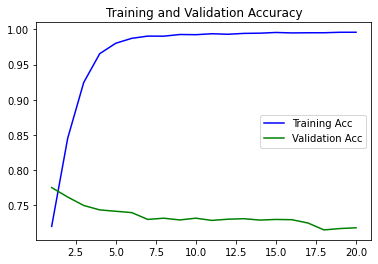

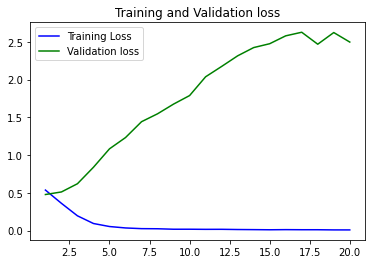

In [ ]:
# plotting the results

acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

epochs = range(1, 21)
plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'g', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
from keras import regularizers
from keras.callbacks import ModelCheckpoint
model= Sequential()
model.add(layers.Embedding(vocab_size, 100, input_length=max_len))
model.add(layers.Conv1D(32, 8, activation="relu"))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1,  activation="sigmoid"))   
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
#modelHistory = model.fit(train_text,y_train, validation_data= ( test_text , y_test),epochs=100)
history = model.fit(train_text, y_train, epochs=20,validation_data=(test_text, y_test))

Epoch 1/20
1340/1340 [==============================] - 8s 6ms/step - loss: 0.5290 - accuracy: 0.7313 - val_loss: 0.4782 - val_accuracy: 0.7745
Epoch 2/20
1340/1340 [==============================] - 8s 6ms/step - loss: 0.3540 - accuracy: 0.8474 - val_loss: 0.5294 - val_accuracy: 0.7646
Epoch 3/20
1340/1340 [==============================] - 8s 6ms/step - loss: 0.1893 - accuracy: 0.9266 - val_loss: 0.6671 - val_accuracy: 0.7481
Epoch 4/20
1340/1340 [==============================] - 8s 6ms/step - loss: 0.0884 - accuracy: 0.9683 - val_loss: 0.8980 - val_accuracy: 0.7413
Epoch 5/20
1340/1340 [==============================] - 8s 6ms/step - loss: 0.0493 - accuracy: 0.9827 - val_loss: 1.1109 - val_accuracy: 0.7375
Epoch 6/20
1340/1340 [==============================] - 7s 5ms/step - loss: 0.0335 - accuracy: 0.9878 - val_loss: 1.3854 - val_accuracy: 0.7345
Epoch 7/20
1340/1340 [==============================] - 8s 6ms/step - loss: 0.0303 - accuracy: 0.9888 - val_loss: 1.5604 - val_accuracy:

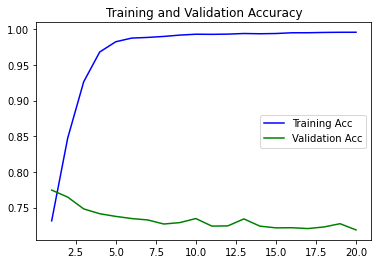

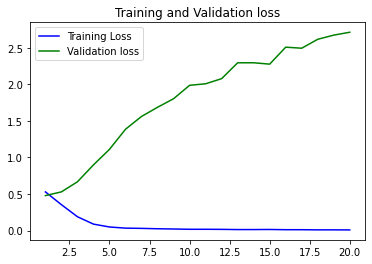

In [ ]:
# plotting the results

acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'g', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

#### Setting up the RNN Model
RNN models have been implemented using sequential models from the Keras API. 
Differential Model complexity is achieved by varying the following:
A) Number of hidden layers
B) Number of Neuron units in each layer Essentially, I'll start 

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
train_text, train_polarity = tfds.as_numpy(tfds.load('sentiment140', split='train[:4%]', shuffle_files=True, batch_size=-1,
    as_supervised=True ))
train_text = clean_v_func(train_text)
train_text = convert_v_func(train_text)
max_words = 5000
#max_len = 200
max_len=max([len(row.split()) for row in train_text])

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_text)
sequences = tokenizer.texts_to_sequences(train_text)
tweets = pad_sequences(sequences, maxlen=max_len)


In [ ]:
from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)

In [ ]:
labels = train_polarity

y = []
for i in range(len(labels)):
    if labels[i] == 0:
        y.append(0)
    if labels[i] == 4:
        y.append(1)

y = np.array(y)

labels = tf.keras.utils.to_categorical(y, dtype="int32")
del y
print (labels[:6])

[[0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, test_size=0.33, random_state=42)
print ((X_train.shape),(X_test.shape),(y_train.shape),(y_test.shape))

(42880, 375) (21120, 375) (42880, 2) (21120, 2)


In [ ]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

### Model1: 
A single Layer LSTM

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20,input_length=max_len))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(2,activation='softmax'))

model1.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/20
1338/1340 [============================>.] - ETA: 0s - loss: 0.5645 - accuracy: 0.7072
Epoch 1: val_accuracy improved from -inf to 0.75516, saving model to best_model1.hdf5
1340/1340 [==============================] - 27s 18ms/step - loss: 0.5643 - accuracy: 0.7073 - val_loss: 0.5054 - val_accuracy: 0.7552
Epoch 2/20
1339/1340 [============================>.] - ETA: 0s - loss: 0.4859 - accuracy: 0.7706
Epoch 2: val_accuracy improved from 0.75516 to 0.76771, saving model to best_model1.hdf5
1340/1340 [==============================] - 25s 19ms/step - loss: 0.4859 - accuracy: 0.7705 - val_loss: 0.4876 - val_accuracy: 0.7677
Epoch 3/20
1337/1340 [============================>.] - ETA: 0s - loss: 0.4669 - accuracy: 0.7811
Epoch 3: val_accuracy improved from 0.76771 to 0.76823, saving model to best_model1.hdf5
1340/1340 [==============================] - 25s 19ms/step - loss: 0.4669 - accuracy: 0.7810 - val_loss: 0.4916 - val_accuracy: 0.7682
Epoch 4/20
1337/1340 [===============

[0.7072761058807373, 0.77052241563797, 0.7809934616088867, 0.7867537140846252, 0.7897388339042664, 0.7918843030929565, 0.794309675693512, 0.7978078126907349, 0.7977378964424133, 0.8012360334396362, 0.8011193871498108, 0.8032882213592529, 0.805060625076294, 0.8049906492233276, 0.8057369589805603, 0.8083022236824036, 0.8098647594451904, 0.8104477524757385, 0.8104011416435242, 0.8112872838973999]
[0.5643373131752014, 0.485925555229187, 0.4669242203235626, 0.4571470022201538, 0.45169034600257874, 0.44715315103530884, 0.44314125180244446, 0.4396372437477112, 0.4378770589828491, 0.43373537063598633, 0.4326869547367096, 0.42947855591773987, 0.4268990159034729, 0.42624592781066895, 0.42283371090888977, 0.4220981001853943, 0.41935160756111145, 0.4177151024341583, 0.4163852035999298, 0.4154195189476013]
[0.5053774118423462, 0.48760607838630676, 0.4916101098060608, 0.47681108117103577, 0.4733407199382782, 0.4722803831100464, 0.47169479727745056, 0.47102993726730347, 0.469821035861969, 0.467864423

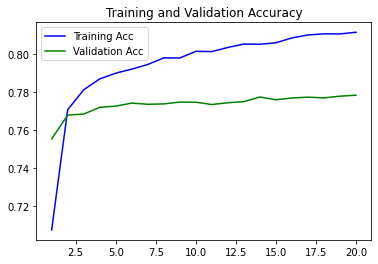

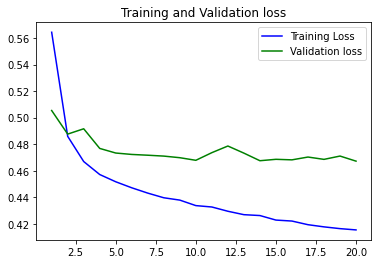

In [ ]:
# plotting the results

acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')
print(acc)
print(loss)
print(val_loss)
epochs = range(1, 21)
print (epochs)

plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'g', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


### Model 2: 
A double Layered LSTM

In [ ]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 20,input_length=max_len))
model2.add(layers.LSTM(15,dropout=0.5,return_sequences = True))
model2.add(layers.LSTM(units = 15,dropout=0.5, return_sequences = False))
model2.add(layers.Dense(2,activation='softmax'))

model2.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/20
1339/1340 [============================>.] - ETA: 0s - loss: 0.5748 - accuracy: 0.7002
Epoch 1: val_accuracy improved from -inf to 0.75805, saving model to best_model2.hdf5
1340/1340 [==============================] - 53s 38ms/step - loss: 0.5749 - accuracy: 0.7003 - val_loss: 0.5042 - val_accuracy: 0.7580
Epoch 2/20
1339/1340 [============================>.] - ETA: 0s - loss: 0.4915 - accuracy: 0.7668
Epoch 2: val_accuracy improved from 0.75805 to 0.76435, saving model to best_model2.hdf5
1340/1340 [==============================] - 48s 36ms/step - loss: 0.4916 - accuracy: 0.7667 - val_loss: 0.4875 - val_accuracy: 0.7643
Epoch 3/20
1339/1340 [============================>.] - ETA: 0s - loss: 0.4706 - accuracy: 0.7808
Epoch 3: val_accuracy improved from 0.76435 to 0.76662, saving model to best_model2.hdf5
1340/1340 [==============================] - 49s 37ms/step - loss: 0.4706 - accuracy: 0.7808 - val_loss: 0.4818 - val_accuracy: 0.7666
Epoch 4/20
1339/1340 [===============

[0.7002565264701843, 0.7666744589805603, 0.7808068990707397, 0.785937488079071, 0.7903684973716736, 0.791627824306488, 0.7936100959777832, 0.7964785695075989, 0.7970382571220398, 0.7981110215187073, 0.8001165986061096, 0.8006296753883362, 0.8032649159431458, 0.8055037260055542, 0.8052005767822266, 0.806273341178894, 0.8051306009292603, 0.8069496154785156, 0.8071128726005554, 0.8079057931900024]
[0.5748934745788574, 0.4916088581085205, 0.47063905000686646, 0.4617633521556854, 0.4535107910633087, 0.4506170153617859, 0.44661882519721985, 0.4436752498149872, 0.4420618414878845, 0.43973320722579956, 0.43810752034187317, 0.43511515855789185, 0.4329075515270233, 0.4308074414730072, 0.42983585596084595, 0.4281069040298462, 0.4279782474040985, 0.42640286684036255, 0.42630261182785034, 0.4251079857349396]
[0.5042362809181213, 0.48754119873046875, 0.4818371534347534, 0.4782625138759613, 0.4834694266319275, 0.47641119360923767, 0.47724664211273193, 0.47283631563186646, 0.4758899509906769, 0.474978

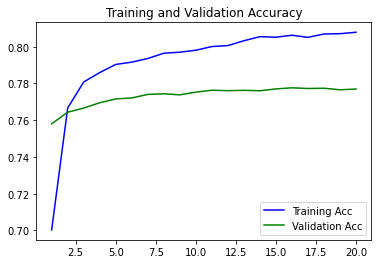

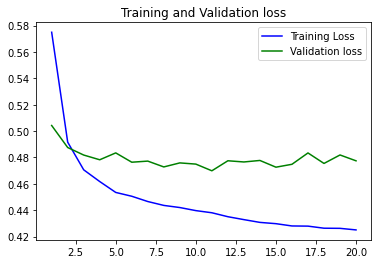

In [ ]:
# plotting the results

acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')
print(acc)
print(loss)
print(val_loss)
epochs = range(1, 21)
print (epochs)

plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'g', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

### Model 3: 
A triple Layered LSTM

In [ ]:
model3 = Sequential()
model3.add(layers.Embedding(max_words, 20,input_length=max_len))
model3.add(layers.LSTM(15,dropout=0.5,return_sequences = True))
model3.add(layers.LSTM(units = 15,dropout=0.5, return_sequences = True))
model3.add(layers.LSTM(units = 15,dropout=0.5, return_sequences = False))
model3.add(layers.Dense(2,activation='softmax'))

model3.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/20
1340/1340 [==============================] - ETA: 0s - loss: 0.5875 - accuracy: 0.6809
Epoch 1: val_accuracy improved from -inf to 0.75388, saving model to best_model3.hdf5
1340/1340 [==============================] - 77s 54ms/step - loss: 0.5875 - accuracy: 0.6809 - val_loss: 0.5091 - val_accuracy: 0.7539
Epoch 2/20
1340/1340 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.7630
Epoch 2: val_accuracy improved from 0.75388 to 0.76212, saving model to best_model3.hdf5
1340/1340 [==============================] - 72s 54ms/step - loss: 0.5004 - accuracy: 0.7630 - val_loss: 0.4957 - val_accuracy: 0.7621
Epoch 3/20
1339/1340 [============================>.] - ETA: 0s - loss: 0.4792 - accuracy: 0.7777
Epoch 3: val_accuracy improved from 0.76212 to 0.76624, saving model to best_model3.hdf5
1340/1340 [==============================] - 72s 54ms/step - loss: 0.4792 - accuracy: 0.7777 - val_loss: 0.4849 - val_accuracy: 0.7662
Epoch 4/20
1339/1340 [===============

[0.6809002161026001, 0.7629663944244385, 0.7777052521705627, 0.7836287021636963, 0.7887359857559204, 0.7890858054161072, 0.7946361899375916, 0.7940765023231506, 0.7971781492233276, 0.7981576323509216, 0.8003498315811157, 0.8007462620735168, 0.8013759255409241, 0.8017957210540771, 0.8035447597503662, 0.8042677044868469, 0.806273341178894, 0.8066697716712952, 0.8081389665603638, 0.8089552521705627]
[0.5875165462493896, 0.5004152655601501, 0.4791983664035797, 0.4678001403808594, 0.4587003290653229, 0.4547082781791687, 0.4492131471633911, 0.44674378633499146, 0.4438111186027527, 0.44129088521003723, 0.4410697817802429, 0.4387434720993042, 0.4365287721157074, 0.4338564872741699, 0.4332836866378784, 0.43049749732017517, 0.43068674206733704, 0.42824405431747437, 0.42670387029647827, 0.4270063638687134]
[0.509067714214325, 0.4957297444343567, 0.4849430322647095, 0.4846324622631073, 0.4781562089920044, 0.4813333749771118, 0.4739669859409332, 0.48557114601135254, 0.4810103476047516, 0.4725076854

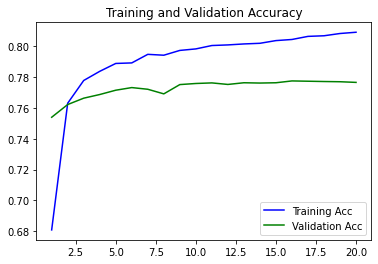

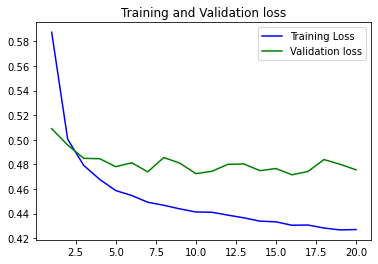

In [ ]:
# plotting the results

acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')
print(acc)
print(loss)
print(val_loss)
epochs = range(1, 21)
print (epochs)

plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'g', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

### Model 4: 
Varying the units in  hidden layers of a triple layered LSTM

In [ ]:
history_data = []

neurons = [5,15,25]
for i in neurons:
  model4 = Sequential()
  model4.add(layers.Embedding(max_words, 20,input_length=max_len))
  model4.add(layers.LSTM(i,dropout=0.5,return_sequences = True))
  model4.add(layers.LSTM(units = i,dropout=0.5, return_sequences = False))
  model4.add(layers.Dense(2,activation='softmax'))
  model4.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
  #Implementing model checkpoins to save the best metric and do not lose it on training.
  #checkpoint1 = ModelCheckpoint("best_model4.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
  history = model4.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test))
  history_data.append(history)

Epoch 1/20
1340/1340 [==============================] - 49s 35ms/step - loss: 0.6023 - accuracy: 0.6767 - val_loss: 0.5255 - val_accuracy: 0.7499
Epoch 2/20
1340/1340 [==============================] - 46s 35ms/step - loss: 0.5095 - accuracy: 0.7602 - val_loss: 0.4989 - val_accuracy: 0.7647
Epoch 3/20
1340/1340 [==============================] - 44s 32ms/step - loss: 0.4863 - accuracy: 0.7746 - val_loss: 0.4933 - val_accuracy: 0.7665
Epoch 4/20
1340/1340 [==============================] - 46s 35ms/step - loss: 0.4741 - accuracy: 0.7833 - val_loss: 0.4958 - val_accuracy: 0.7658
Epoch 5/20
1340/1340 [==============================] - 44s 33ms/step - loss: 0.4688 - accuracy: 0.7859 - val_loss: 0.4942 - val_accuracy: 0.7681
Epoch 6/20
1340/1340 [==============================] - 44s 33ms/step - loss: 0.4618 - accuracy: 0.7888 - val_loss: 0.4849 - val_accuracy: 0.7711
Epoch 7/20
1340/1340 [==============================] - 44s 33ms/step - loss: 0.4567 - accuracy: 0.7906 - val_loss: 0.4804 -

[0.6766790747642517, 0.7601912021636963, 0.7746268510818481, 0.7833255529403687, 0.7858675122261047, 0.7887593507766724, 0.7906249761581421, 0.7935401201248169, 0.7914178967475891, 0.7937732934951782, 0.798041045665741, 0.7985774278640747, 0.7973647117614746, 0.8023087978363037, 0.7999767065048218, 0.8014692068099976, 0.8010494112968445, 0.8052938580513, 0.804874062538147, 0.8049207329750061]
[0.6022629737854004, 0.5095149278640747, 0.48628726601600647, 0.47411832213401794, 0.4688059687614441, 0.4618012309074402, 0.45669713616371155, 0.45435017347335815, 0.4524983763694763, 0.4484226107597351, 0.4449140429496765, 0.44343626499176025, 0.4438243806362152, 0.4394853711128235, 0.43899860978126526, 0.4372538924217224, 0.43683862686157227, 0.4332083761692047, 0.4328806400299072, 0.43271365761756897]
[0.5255181193351746, 0.4989033639431, 0.4932955205440521, 0.4957827925682068, 0.4942387342453003, 0.48489657044410706, 0.4803609251976013, 0.4827868342399597, 0.4837062954902649, 0.48370286822319

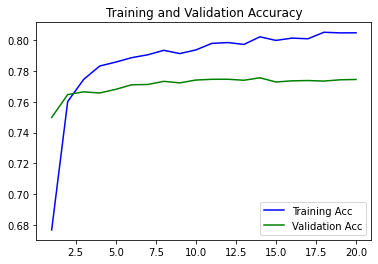

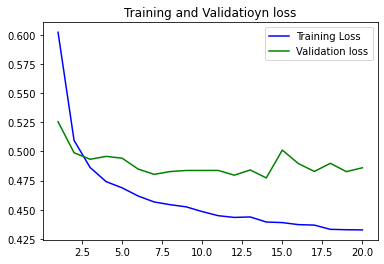

[0.6896222233772278, 0.7668610215187073, 0.780457079410553, 0.784958004951477, 0.7886660695075989, 0.7913945913314819, 0.7933068871498108, 0.7947527766227722, 0.7946828603744507, 0.7969449758529663, 0.7992070913314819, 0.8002798557281494, 0.8015158772468567, 0.8026352524757385, 0.8043609857559204, 0.803894579410553, 0.8030317425727844, 0.8063432574272156, 0.8067164421081543, 0.8081156611442566]
[0.5778828859329224, 0.49142885208129883, 0.4733632206916809, 0.4638881981372833, 0.4569055736064911, 0.45223763585090637, 0.44794848561286926, 0.4452732503414154, 0.4436219036579132, 0.4409261643886566, 0.4391384720802307, 0.4353172779083252, 0.4334569573402405, 0.43294626474380493, 0.43175607919692993, 0.4305844008922577, 0.43033215403556824, 0.42692747712135315, 0.4273897111415863, 0.42551159858703613]
[0.5041282773017883, 0.4912038743495941, 0.48227062821388245, 0.48352929949760437, 0.4889722764492035, 0.4846709370613098, 0.4789196252822876, 0.488393098115921, 0.47629716992378235, 0.47849658

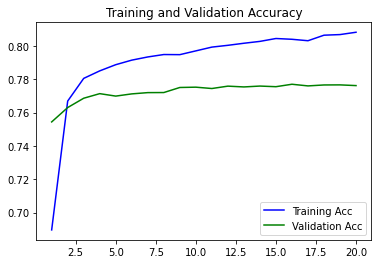

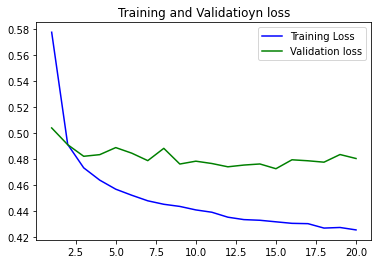

[0.7033815383911133, 0.7712219953536987, 0.7798274159431458, 0.7840484976768494, 0.7876632213592529, 0.793166995048523, 0.7940765023231506, 0.7973181009292603, 0.7994169592857361, 0.7988106608390808, 0.8024020791053772, 0.802541971206665, 0.8061100840568542, 0.8064132332801819, 0.8091651201248169, 0.808582067489624, 0.8097947835922241, 0.8103078603744507, 0.8094449639320374, 0.8118470311164856]
[0.566540002822876, 0.48443499207496643, 0.46936851739883423, 0.46177372336387634, 0.4558647871017456, 0.4497823119163513, 0.446985125541687, 0.4408836364746094, 0.43860262632369995, 0.4375961422920227, 0.43387454748153687, 0.43189793825149536, 0.4279218912124634, 0.42570409178733826, 0.42278769612312317, 0.4238831400871277, 0.42023611068725586, 0.42062851786613464, 0.4188777208328247, 0.4167466461658478]
[0.4996700882911682, 0.48931702971458435, 0.4885924756526947, 0.4839823544025421, 0.47941750288009644, 0.47574716806411743, 0.47652938961982727, 0.4776866137981415, 0.47444766759872437, 0.47440

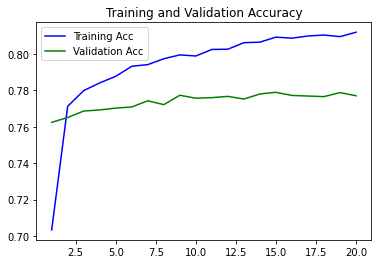

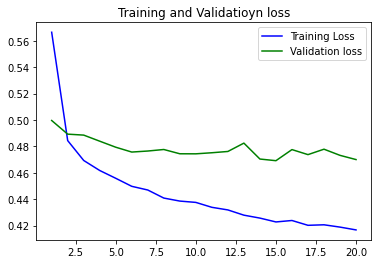

In [ ]:
# plotting the results
for history in history_data:
  acc = history.history.get('accuracy')
  val_acc = history.history.get('val_accuracy')
  loss = history.history.get('loss')
  val_loss = history.history.get('val_loss')
  print(acc)
  print(loss)
  print(val_loss)
  epochs = range(1, 21)
  print (epochs)

  plt.plot(epochs, acc, 'b', label='Training Acc')
  plt.plot(epochs, val_acc, 'g', label='Validation Acc')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label="Training Loss")
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title('Training and Validatioyn loss')
  plt.legend()
  plt.show()

### Testing if double descent occurs by increasing in number of epochs 
We have tested by training models with more complexity by increasing number of layers to try and see double descent now let us try out and see if we can observe a double descent with the increase in number of epochs.
A single Layer LSTM (Testing with 200 epoches to try and observe if there is double descent when number of epoches are increased)

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20,input_length=max_len))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(2,activation='softmax'))

model1.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=125,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/125
1338/1340 [============================>.] - ETA: 0s - loss: 0.5626 - accuracy: 0.7060
Epoch 1: val_accuracy improved from -inf to 0.76373, saving model to best_model1.hdf5
1340/1340 [==============================] - 26s 18ms/step - loss: 0.5627 - accuracy: 0.7060 - val_loss: 0.4987 - val_accuracy: 0.7637
Epoch 2/125
1338/1340 [============================>.] - ETA: 0s - loss: 0.4831 - accuracy: 0.7711
Epoch 2: val_accuracy improved from 0.76373 to 0.76738, saving model to best_model1.hdf5
1340/1340 [==============================] - 25s 19ms/step - loss: 0.4832 - accuracy: 0.7711 - val_loss: 0.4874 - val_accuracy: 0.7674
Epoch 3/125
1339/1340 [============================>.] - ETA: 0s - loss: 0.4663 - accuracy: 0.7795
Epoch 3: val_accuracy improved from 0.76738 to 0.76875, saving model to best_model1.hdf5
1340/1340 [==============================] - 25s 18ms/step - loss: 0.4663 - accuracy: 0.7794 - val_loss: 0.4824 - val_accuracy: 0.7688
Epoch 4/125
1337/1340 [===========

[0.7060167789459229, 0.7710821032524109, 0.7794309854507446, 0.7861940264701843, 0.7897388339042664, 0.79197758436203, 0.7944263219833374, 0.7976446151733398, 0.7969216704368591, 0.7982509136199951, 0.8015857934951782, 0.7996968030929565, 0.8044776320457458, 0.8046875, 0.805480420589447, 0.8077658414840698, 0.8073461055755615, 0.8077192306518555, 0.8082322478294373, 0.8097714781761169, 0.8106343150138855, 0.812313437461853, 0.811707079410553, 0.8142490386962891, 0.8138992786407471, 0.8143889904022217, 0.8141791224479675, 0.8149020671844482, 0.8155550360679626, 0.8165578246116638, 0.8163012862205505, 0.8167910575866699, 0.8170709013938904, 0.8193097114562988, 0.8201725482940674, 0.8198927044868469, 0.8184934854507446, 0.8205923438072205, 0.8208954930305481, 0.8219449520111084, 0.8201959133148193, 0.8229944109916687, 0.8236007690429688, 0.8233442306518555, 0.8218283653259277, 0.8223180770874023, 0.8238572478294373, 0.8247201442718506, 0.8238339424133301, 0.8237406611442566, 0.82269120216

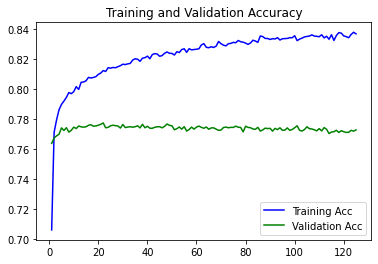

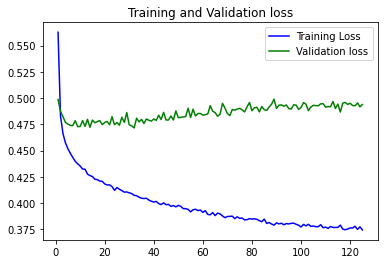

In [ ]:
# plotting the results

acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')
print(acc)
print(loss)
print(val_loss)
epochs = range(1, 126)
print (epochs)

plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'g', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


### Model7: Testing if double descent occurs by increasing the amount of data we use for training
We are going to use 4 times the data we used previously with the same Model 1 architecture(Single layer LSTM) to try and see if we can observe the double descent phenomenon. 

In [ ]:
ds_train, ds_train_info = tfds.load('sentiment140', split='train[:16%]', shuffle_files=True ,with_info = True) # Loading a built in tensorflow dataset
# Using it as a numpy array
train_text, train_polarity = tfds.as_numpy(tfds.load('sentiment140', split='train[:16%]', shuffle_files=True, batch_size=-1,as_supervised=True ))
# Applying function to numpy
train_text = clean_v_func(train_text)
train_text = convert_v_func(train_text)
Y_Tr = train_polarity

In [ ]:
max_words = 5000
#max_len = 200
max_len=max([len(row.split()) for row in train_text])

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_text)
sequences = tokenizer.texts_to_sequences(train_text)
tweets = pad_sequences(sequences, maxlen=max_len)
labels = train_polarity

y = []
for i in range(len(labels)):
    if labels[i] == 0:
        y.append(0)
    if labels[i] == 4:
        y.append(1)

y = np.array(y)
labels = tf.keras.utils.to_categorical(y, dtype="int32")
del y
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, test_size=0.33, random_state=42)
print ((X_train.shape),(X_test.shape),(y_train.shape),(y_test.shape))
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20,input_length=max_len))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(2,activation='softmax'))

model1.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test),callbacks=[checkpoint1])

(171520, 569) (84480, 569) (171520, 2) (84480, 2)


Epoch 1/20
5359/5360 [============================>.] - ETA: 0s - loss: 0.5057 - accuracy: 0.7530
Epoch 1: val_accuracy improved from -inf to 0.77880, saving model to best_model1.hdf5
5360/5360 [==============================] - 165s 30ms/step - loss: 0.5057 - accuracy: 0.7530 - val_loss: 0.4681 - val_accuracy: 0.7788
Epoch 2/20
5358/5360 [============================>.] - ETA: 0s - loss: 0.4648 - accuracy: 0.7812
Epoch 2: val_accuracy improved from 0.77880 to 0.78593, saving model to best_model1.hdf5
5360/5360 [==============================] - 165s 31ms/step - loss: 0.4648 - accuracy: 0.7812 - val_loss: 0.4603 - val_accuracy: 0.7859
Epoch 3/20
5359/5360 [============================>.] - ETA: 0s - loss: 0.4574 - accuracy: 0.7855
Epoch 3: val_accuracy improved from 0.78593 to 0.78823, saving model to best_model1.hdf5
5360/5360 [==============================] - 168s 31ms/step - loss: 0.4574 - accuracy: 0.7855 - val_loss: 0.4560 - val_accuracy: 0.7882
Epoch 4/20
5358/5360 [============

[0.7530433535575867, 0.7811567187309265, 0.7855119109153748, 0.7881588339805603, 0.7912896275520325, 0.7923449277877808, 0.7927530407905579, 0.7945720553398132, 0.7951608896255493, 0.7947527766227722, 0.7959246635437012, 0.7971140146255493, 0.79783695936203, 0.7969624400138855, 0.7978253364562988, 0.7987756729125977, 0.7981051802635193, 0.7975338101387024, 0.7981576323509216, 0.7976387739181519]
[0.5056870579719543, 0.4648328125476837, 0.4574441909790039, 0.452284038066864, 0.4491994380950928, 0.4463503658771515, 0.44475844502449036, 0.44323861598968506, 0.4418865144252777, 0.4414292573928833, 0.4397609531879425, 0.4398796856403351, 0.43861716985702515, 0.439566045999527, 0.4382076859474182, 0.4375480115413666, 0.4376392364501953, 0.4374673068523407, 0.43646863102912903, 0.4374856948852539]
[0.4681154191493988, 0.46031999588012695, 0.4560072124004364, 0.45105013251304626, 0.45065978169441223, 0.44892463088035583, 0.4482990503311157, 0.44650593400001526, 0.4445965886116028, 0.4441958665

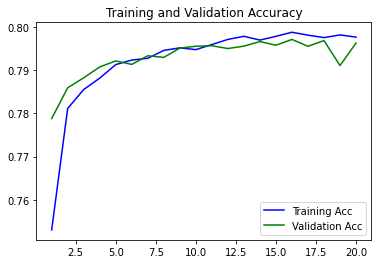

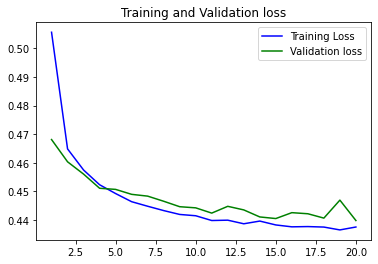

In [ ]:
# plotting the results

acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')
print(acc)
print(loss)
print(val_loss)
epochs = range(1, 21)
print (epochs)

plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'g', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()
